# Screening

![pytdgl logo](https://raw.githubusercontent.com/loganbvh/py-tdgl/main/docs/images/logo-transparent-small.png)

By default `pyTDGL` assumes that screening is negligible, i.e., that the total vector potential in the film is equal to the applied vector potential: $\mathbf{A}(\mathbf{r}, t)=\mathbf{A}_\mathrm{applied}(\mathbf{r}, t)$.
Screening can optionally be included by evaluating the vector potential induced by currents flowing in the film.
The vector potential in a 2D film induced by a sheet current density $\mathbf{K}$ flowing in the film is given by

$$
    \mathbf{A}_\mathrm{induced}(\mathbf{r}, t) =
    \frac{\mu_0}{4\pi}\int_\mathrm{film}\frac{\mathbf{K}(\mathbf{r}', t)}{|\mathbf{r}-\mathbf{r}'|}\,\mathrm{d}^2\mathbf{r}'.
$$

Taking the induced vector potential into account, the total vector potential in the film is $\mathbf{A}(\mathbf{r}, t)=\mathbf{A}_\mathrm{applied}(\mathbf{r}, t)+\mathbf{A}_\mathrm{induced}(\mathbf{r}, t).$

Because $\mathbf{A} =\mathbf{A}_\mathrm{applied}+\mathbf{A}_\mathrm{induced}$ enters into the covariant gradient and Laplacian of $\psi$, which in turn determine the current density $\mathbf{J}=\mathbf{K}/d$,
which determines $\mathbf{A}_\mathrm{induced}$, the system must be solved self-consistently at each time step $t^n$.
The strategy for updating the induced vector potential to converge to a self-consistent value is based on [Polyak's
"heavy ball" method](https://www.sciencedirect.com/science/article/pii/0041555364901375):

$$
\begin{split}
    \mathbf{A}^{n,s}_{\mathrm{induced},ij} &= \frac{\mu_0}{4\pi}\sum_{\text{sites } \ell}\frac{\mathbf{K}^{n,s}_\ell}{|\mathbf{r}_{ij}-\mathbf{r}_\ell|}a_\ell\\
    \mathbf{d}^{n,s}_{ij} &= \mathbf{A}^{n,s}_{\mathrm{induced},ij} - \mathbf{A}^{n,s-1}_{\mathrm{induced},ij}\\
    \mathbf{v}^{n,s+1} &= (1-\beta)\mathbf{v}^{n,s} + \alpha\mathbf{d}^{n,s}_{ij}\\
    \mathbf{A}^{n,s+1}_{\mathrm{induced},ij} &= \mathbf{A}^{n,s}_{\mathrm{induced},ij} + \mathbf{v}^{n,s+1}_{ij}
\end{split}
$$

The integer index $s$ counts the number of iterations performed in the self-consistent calculation.
The parameters $\alpha\in(0,\infty)$ (the `screening_step_size`) and $\beta\in(0,1)$ (the `screening_drag`) can be set by the user,
and the initial conditions for $\mathbf{A}^{n,0}_{\mathrm{induced},ij} = \mathbf{A}^{n-1}_{\mathrm{induced},ij}$
and $\mathbf{v}^{n,0}_{ij} = \mathbf{0}$. The iterative application of the above equation terminates when the relative change in the induced vector potential between iterations falls below a user-defined tolerance (the `screening_tolerance`). The `screening_step_size` $\alpha$  and `screening_drag` $\beta$ determine the rate of convergence to the `screening_tolerance`.

In the equation above, we evaluate the sheet current density $\mathbf{K}^n_\ell=\mathbf{K}(\mathbf{r}_\ell,t^n)$ on the mesh sites $\mathbf{r}_\ell$ and the vector potential on the mesh edges $\mathbf{r}_{ij}$, so the denominator
$|\mathbf{r}_{ij}-\mathbf{r}_\ell|$ is strictly greater than zero and the equation is well-defined.
This method involves the pairwise distances between all edges and all sites in the mesh, so,
in contrast to the sparse finite volume calculation, it is a "dense" problem. This means that
including screening significantly increases the number of floating point operations required for a
TDGL simulation.

A simple way to determine whether screening is non-negligible for a given model is to evaluate the fluxoid for a region inside a film for a small applied field, where the normalized order parameter $\psi(\mathbf{r})=1$ everywhere. In this regime, the total fluxoid for a region containing no vortices should exactly vanish, as predicted by the London model. A fluxoid that differs significantly from zero when the model is solved without screening therefore indicates that screening should not be neglected, as demonstrated below.

In [1]:
# Automatically install tdgl from GitHub only if running in Google Colab
if "google.colab" in str(get_ipython()):
    %pip install --quiet git+https://github.com/loganbvh/py-tdgl.git
    !apt install ffmpeg

In [2]:
%config InlineBackend.figure_formats = {"retina", "png"}

import os
os.environ["OPENBLAS_NUM_THREADS"] = "1"

import matplotlib.pyplot as plt
import numpy as np

plt.rcParams["figure.figsize"] = (7.5, 2.5)

import tdgl
from tdgl.geometry import box, circle

### Defining the device

Here we define a film with effective magnetic screening length $\Lambda=\lambda^2/d=(0.075\,\mu\mathrm{m})^2 / (0.05\,\mu\mathrm{m})=0.1125\,\mu\mathrm{m}$, which is much smaller than the dimensions of the sample. We therefore expect screening to be important for this model.

In [3]:
length_units = "um"
xi = 0.1
london_lambda = 0.075
thickness = 0.05

height = 1
width = 2

layer = tdgl.Layer(coherence_length=xi, london_lambda=london_lambda, thickness=thickness)
film = tdgl.Polygon("film", points=tdgl.geometry.box(width, height, points=301))
device = tdgl.Device(
    "bar",
    layer=layer,
    film=film,
    length_units=length_units,
)

fluxoid_curves = [
    circle(0.25, center=(0, 0)),
    circle(0.1, center=(0.15, 0.25)),
    circle(0.3, center=(0.6, -0.1)),
    box(0.5, center=(-0.5, 0)),
    box(0.5, center=(-0.6, -0.2)),
]

In [4]:
device.make_mesh(max_edge_length=xi / 2, smooth=100)

Constructing Voronoi polygons: 100%|█████| 2862/2862 [00:00<00:00, 23506.57it/s]


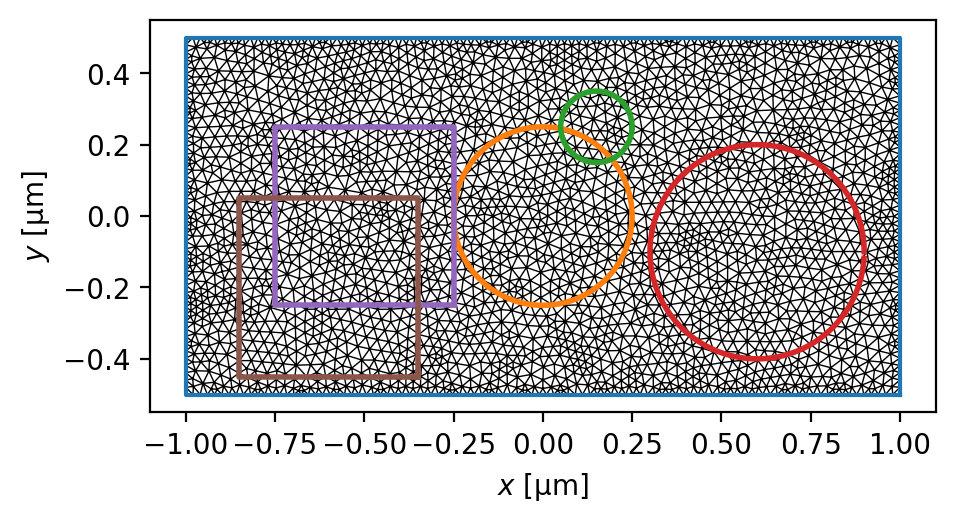

In [5]:
fig, ax = device.plot(mesh=True, legend=False)
for curve in fluxoid_curves:
    ax.plot(*curve.T, lw=2)

In [6]:
device.mesh_stats()

num_sites,2862
num_elements,5426
min_edge_length,1.285e-02
max_edge_length,4.828e-02
mean_edge_length,2.896e-02
min_area,9.328e-05
max_area,1.446e-03
mean_area,6.988e-04
coherence_length,1.000e-01
length_units,um


## Solve the model

### Without screening

In [7]:
options = tdgl.SolverOptions(
    solve_time=5,
    field_units="mT",
    current_units="uA",
    include_screening=False,
)

no_screening_solution = tdgl.solve(device, options, applied_vector_potential=0.1)

Simulating: 100%|██████████████████████████████▉| 5/5 [00:00<00:00, 11.08tau/s ]


When screening is neglected, the Meissner supercurrent density is larger than predicted by London theory, meaning that the total vector potential $\mathbf{A}$ and supercurrent density $\mathbf{J}_s$ are not consistent, leading to a nonzero fluxoid $\Phi_C$ for curve $C$. In other words, the supercurrent does not "know" that some of the applied magnetic field should have been screened via the Meissner effect, so the supercurrent is responding to a larger magnetic field than would be present in a self-consistent scenario. We can quantify the error in the fluxoid by the ratio

$$
\begin{split}
\Phi_C &= \Phi_C^\mathrm{flux} + \Phi_C^\mathrm{supercurrent}\\
&= \oint_C\mathbf{A}(\mathbf{r})\cdot\mathrm{d}\mathbf{r}
    +\oint_C\mu_0\Lambda(\mathbf{r})\mathbf{K}_s(\mathbf{r})\cdot\mathrm{d}\mathbf{r}\\
\text{error}&=\left|\frac{\Phi_C^\mathrm{flux} + \Phi_C^\mathrm{supercurrent}}{\Phi_C^\mathrm{flux}}\right|.
\end{split}
$$

Maximum sheet current density: 449.9 µA/µm


Curve 0: total fluxoid -1.260e-02 magnetic_flux_quantum, (error 392.6%)
Curve 1: total fluxoid -1.605e-03 magnetic_flux_quantum, (error 1307.5%)
Curve 2: total fluxoid -1.356e-02 magnetic_flux_quantum, (error 8524.0%)
Curve 3: total fluxoid -1.403e-02 magnetic_flux_quantum, (error 651.0%)
Curve 4: total fluxoid -1.019e-02 magnetic_flux_quantum, (error 619.7%)


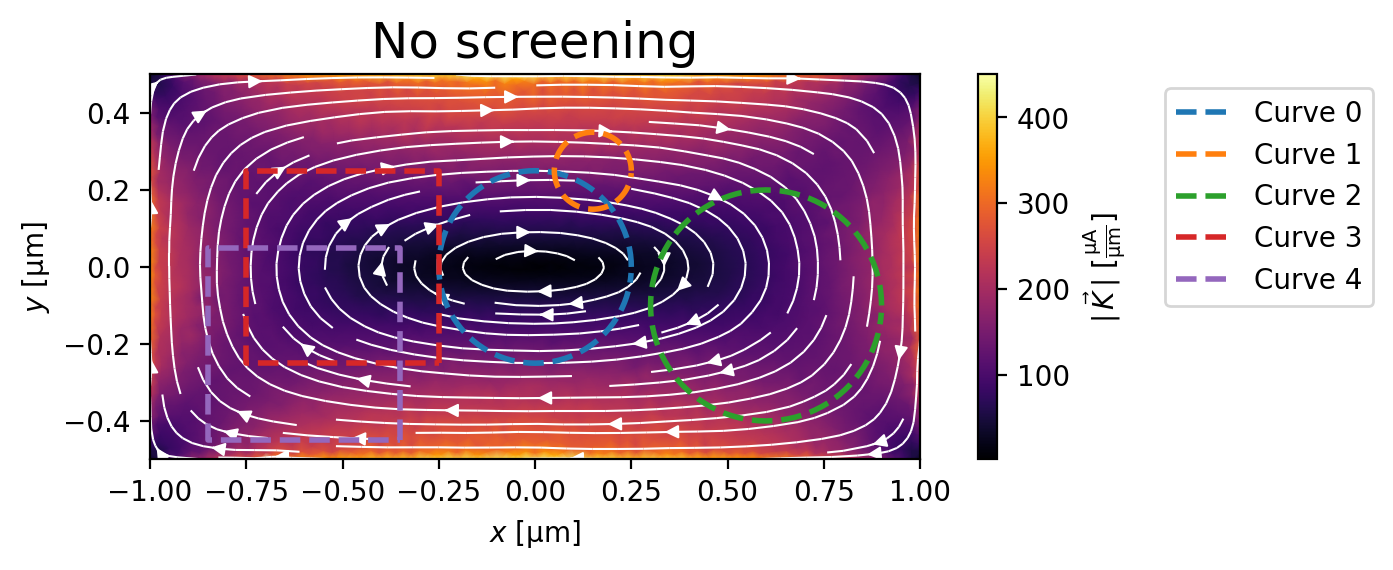

In [8]:
K = no_screening_solution.current_density
K_max = np.sqrt(K[:, 0]**2 + K[:, 1]**2).max()
print(f"Maximum sheet current density: {K_max:.1f~P}")

fig, ax = no_screening_solution.plot_currents()
_ = ax.set_title("No screening", fontsize=18)
for i, curve in enumerate(fluxoid_curves):
    fluxoid = no_screening_solution.polygon_fluxoid(curve)
    total_fluxoid = sum(fluxoid).magnitude
    error = abs(total_fluxoid / fluxoid.flux_part.magnitude)
    print(f"Curve {i}: total fluxoid {sum(fluxoid):.3e}, (error {100* error:.1f}%)")
    ax.plot(*curve.T, "--", lw=2, label=f"Curve {i}")
    
_ = ax.legend(bbox_to_anchor=(1.3, 1), loc="upper left")

### With screening

In [9]:
options = tdgl.SolverOptions(
    solve_time=5,
    field_units="mT",
    current_units="uA",
    include_screening=True,
    screening_tolerance=1e-6,
    dt_max=1e-3,
)

screening_solution = tdgl.solve(device, options, applied_vector_potential=0.1)

Simulating: 100%|██████████████████████████████▉| 5/5 [01:47<00:00, 21.57s/tau ]


When screening is included, the supercurrent density is smaller and the fluxoid $\Phi_C$ is quantized at 0 $\Phi_0$ to within a few percent.

Maximum sheet current density: 269.5 µA/µm
Curve 0: total fluxoid -7.335e-05 magnetic_flux_quantum, (error 2.0%)
Curve 1: total fluxoid -2.532e-05 magnetic_flux_quantum, (error 3.6%)
Curve 2: total fluxoid -3.789e-05 magnetic_flux_quantum, (error 0.6%)
Curve 3: total fluxoid -5.903e-05 magnetic_flux_quantum, (error 1.1%)
Curve 4: total fluxoid 5.284e-05 magnetic_flux_quantum, (error 0.8%)


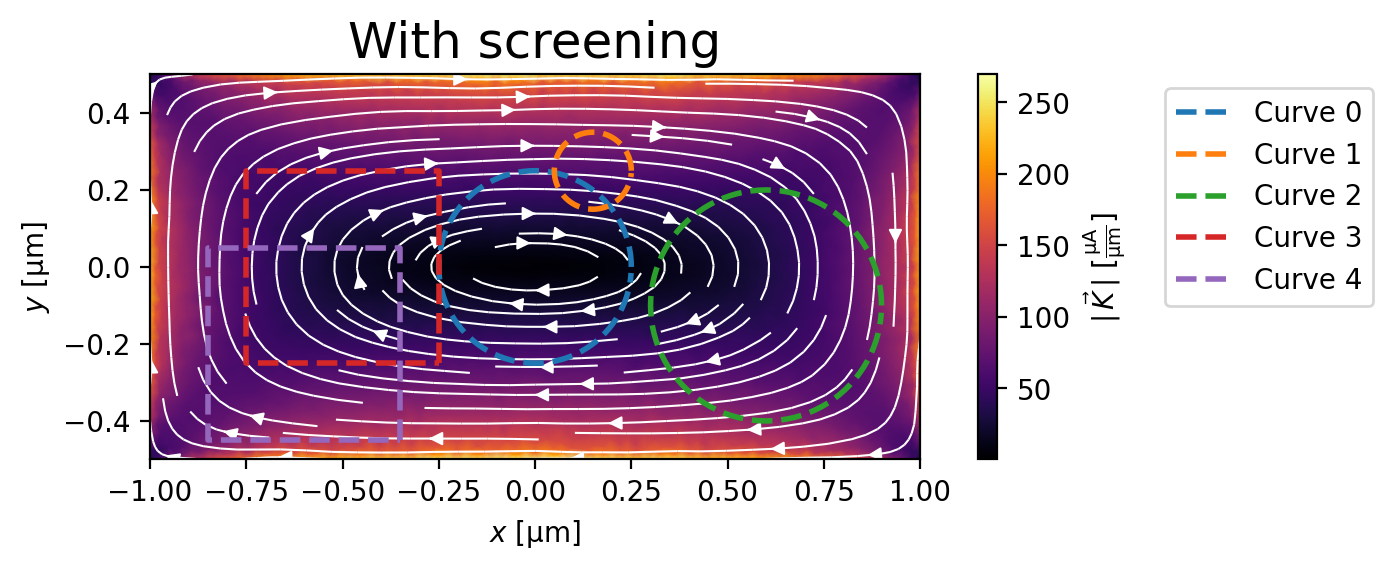

In [10]:
K = screening_solution.current_density
K_max = np.sqrt(K[:, 0]**2 + K[:, 1]**2).max()
print(f"Maximum sheet current density: {K_max:.1f~P}")

fig, ax = screening_solution.plot_currents()
_ = ax.set_title("With screening", fontsize=18)

for i, curve in enumerate(fluxoid_curves):
    ax.plot(*curve.T, "--", lw=2, label=f"Curve {i}")
    fluxoid = screening_solution.polygon_fluxoid(curve)
    total_fluxoid = sum(fluxoid).magnitude
    error = abs(total_fluxoid / fluxoid.flux_part.magnitude)
    print(f"Curve {i}: total fluxoid {sum(fluxoid):.3e}, (error {100 * error:.1f}%)")
    
_ = ax.legend(bbox_to_anchor=(1.3, 1), loc="upper left")

In [11]:
tdgl.version_table()

Software,Version
tdgl,0.5.1; git revision f643d8d [2023-09-21]
Numpy,1.24.3
SciPy,1.10.1
matplotlib,3.7.1
jax,None
numba,0.57.1
IPython,8.14.0
Python,"3.10.11 | packaged by conda-forge | (main, May 10 2023, 19:01:19) [Clang 14.0.6 ]"
OS,posix [darwin]
Number of CPUs,"Physical: 10, Logical: 10"
